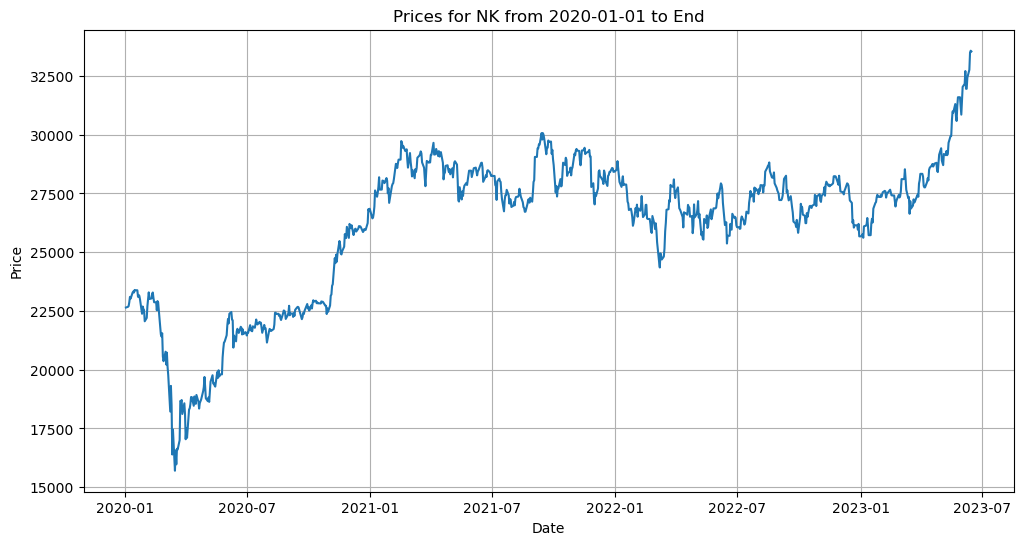

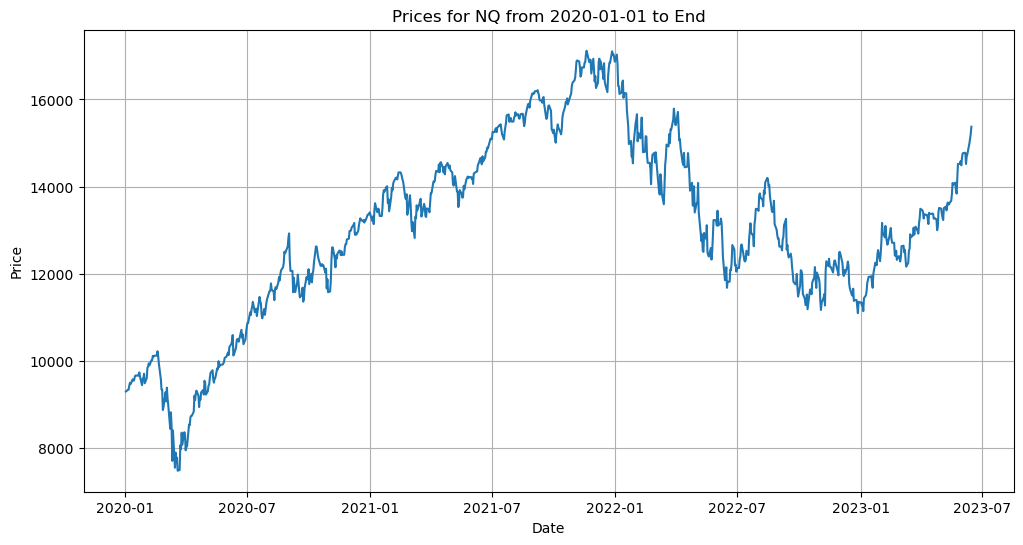

In [25]:
import os
import pandas as pd
import numpy as np

# Directories path for the input and output files
input_directory = 'C:/UA/Data/WLCR'
output_directory = 'C:/CSIPANDAS'

# Initialize an empty DataFrame to store the concatenated data
concatenated_data = pd.DataFrame()

# Define the lookback period. This is used for calculating average log returns.
lookback_period = int(input("Please enter the lookback period: "))

# Define the start date. This is used to filter the data by date.
start_date = input("Please enter the start date (YYYY-MM-DD): ")

# Iterate over each file in the input directory
for filename in os.listdir(input_directory):
    # If the file is a CSV
    if filename.endswith('.csv'):
        file_path = os.path.join(input_directory, filename)
        # Read the CSV file into a DataFrame
        data = pd.read_csv(file_path)
        # Append the data from the CSV file to the concatenated_data DataFrame
        concatenated_data = pd.concat([concatenated_data, data])

# Write the concatenated data to a new CSV file in the output directory
concatenated_data.to_csv(os.path.join(output_directory, 'concatenated_data.csv'), index=False)

# Remove leading and trailing spaces in column names
concatenated_data.columns = concatenated_data.columns.str.strip()
# Remove leading and trailing spaces in data values
concatenated_data = concatenated_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Write the cleaned data to a new CSV file in the output directory
concatenated_data.to_csv(os.path.join(output_directory, 'modified_data.csv'), index=False)

# Convert the 'Date' and 'ExpiryDate' columns to datetime format
concatenated_data['Date'] = pd.to_datetime(concatenated_data['Date'], errors='coerce')
concatenated_data['ExpiryDate'] = pd.to_datetime(concatenated_data['ExpiryDate'], errors='coerce')

# Filter the data to only include rows with a date greater than the specified start date and a symbol different from 'JRU'
concatenated_data = concatenated_data[(concatenated_data['Date'] > start_date) & (concatenated_data['Symbol'] != 'JRU')]

# Pivot the data to have one row per date, one column per symbol, and close prices as values
pivoted_data = concatenated_data.pivot(index='Date', columns='Symbol', values='Close')

# Remove columns with more than 5% missing values
# Then, fill the remaining missing values with the next valid value in the same column (forward fill)
# Finally, drop any remaining rows with missing values
pivoted_data = pivoted_data.dropna(thresh=len(pivoted_data)*0.95, axis=1).fillna(method='ffill').dropna()

# Write the cleaned, pivoted data to a new CSV file in the output directory
pivoted_data.to_csv(os.path.join(output_directory, 'pivoted_data.csv'), index=True)

# Compute the natural logarithm of the prices
log_data = np.log(pivoted_data)
# Compute the daily returns as the difference in log prices
log_returns = log_data.diff().dropna()

# Extract the second to last row of log returns
# Rank the symbols based on their log returns in this row, sorting in descending order
ranked_symbols_log_returns = log_returns.iloc[-1].sort_values(ascending=False)

# Compute the average log returns over the user-specified lookback period for each symbol
# Rank the symbols
# Compute the average log returns over the user-specified lookback period for each symbol
# Rank the symbols based on their average log returns in this period, sorting in descending order
ranked_symbols_average_log_returns = log_returns.iloc[-lookback_period:].mean().sort_values(ascending=False)

# Display the ranked symbols based on their average log returns over the lookback period
'''ranked_symbols_average_log_returns'''

import matplotlib.pyplot as plt

# Function to create the symbol selection prompt
def create_prompt(symbols_list):
    # Start with a basic prompt
    prompt = "Here are the ranked symbols:\n"
    # Append each symbol to the prompt
    for i, symbol in enumerate(symbols_list, 1):
        prompt += f"{i}. {symbol}\n"
    # Append the input prompt at the end
    prompt += "\nPlease enter the number corresponding to the symbol you want to plot: "
    return prompt

# Create a list of symbols
symbols_list = ranked_symbols_average_log_returns.index.tolist()

# Loop until the user decides to stop
while True:
    # Create the prompt for symbol selection
    prompt = create_prompt(symbols_list)

    # Ask the user to select a symbol by entering its corresponding number
    symbol_number = int(input(prompt)) - 1
    selected_symbol = symbols_list[symbol_number]

    # Convert the start_date to a pandas Timestamp
    start_date_timestamp = pd.Timestamp(start_date)

    # Plot the prices for the selected symbol from the start date to the end
    plt.figure(figsize=(12, 6))
    plt.plot(pivoted_data[selected_symbol].loc[start_date_timestamp:])
    plt.title(f'Prices for {selected_symbol} from {start_date} to End')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

    # Ask if the user wants to plot another chart
    continue_plotting = input("\nDo you want to plot another chart? (yes/no): ")

    # If the user doesn't want to continue, break the loop
    if continue_plotting.lower() not in ["yes", "y"]:
        break
